In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('./hockenberry.mplstyle')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

import statsmodels.formula.api as smf
import seaborn as sns

# Defining constants and save directories

The `sparse_data` flag refers to whether I want to use the "full" dataset of gene expression conditions (n = 103) or a more sparsely populated / thinned down dataset containing less redundancy (n=30, where there less underlying structure between the conditions).

In [3]:
import datetime
import os

year = datetime.date.today().year
month = datetime.date.today().month
base_figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(base_figs_dir):
    os.makedirs(base_figs_dir)

In [80]:
data_tag = 'ecoli_full'
# data_tag = 'ecoli_sparse'
# data_tag = 'ecoli_prot'
# data_tag = 'scer_rna'
# data_tag = 'scer_prot'
save_figs = True

if save_figs:
    figs_dir = base_figs_dir+'/{}'.format(data_tag)
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

# Read in the data

In [81]:
if data_tag == 'ecoli_full':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_ecoli.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_ecoli_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_prot':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_ecoli_PROTEIN.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(meta_df.shape)
meta_df.head()

(103, 27)


,Sample ID,Study,Project ID,Condition ID,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,...,Additional Details,DOI,GEO,Simple_sample_id,Temperature (C),pH,Growth Rate (1/hr),Alignment,Replicate #,Doubling_time
4,fur__wt_fe__1,Fur,fur,wt_fe,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms5910,GSE54900,fur__wt_fe,37,7.0,1.060606,92.865,2,0.653539
8,fur__delfur_fe2__1,Fur,fur,delfur_fe2,Escherichia coli K-12 MG1655 del_fur,MG1655,M9,glucose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms5910,GSE54900,fur__delfur_fe2,37,7.0,0.619469,93.020,2,1.118938
55,omics__bw_ac__1,Omics,omics,bw_ac,Escherichia coli BW25113,BW25113,M9,acetate(3.5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_ac,37,7.0,0.203000,97.920,2,3.414518
57,omics__bw_fum__1,Omics,omics,bw_fum,Escherichia coli BW25113,BW25113,M9,fumarate(2.8),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_fum,37,7.0,0.309000,98.130,2,2.243195
59,omics__bw_glc__1,Omics,omics,bw_glc,Escherichia coli BW25113,BW25113,M9,glucose(5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_glc,37,7.0,0.607500,97.875,2,1.140983


In [82]:
if data_tag == 'ecoli_full':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_ecoli.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_ecoli_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_prot':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_ecoli_PROTEIN.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(exp_df.shape)
exp_df.head()

(3923, 103)


,fur__wt_fe,fur__delfur_fe2,omics__bw_ac,omics__bw_fum,omics__bw_glc,omics__bw_pyr,cra_crp__wt_ac,cra_crp__wt_fru,cra_crp__delcra_ac,cra_crp__delcra_fru,...,pal__tartr_ale26_f10,pal__tartr_ale26,pal__tartr_ale28_f10,pal__tartr_ale28,efeU__menFentC_ale39,efeU__menFentC_ale29,efeU__menFentC_ale30,efeU__menFentCubiC_ale36,efeU__menFentCubiC_ale37,efeU__menFentCubiC_ale38
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,10.921941,11.221916,9.219835,9.690669,10.213469,10.706351,9.568949,11.198040,8.487038,11.649292,...,7.907166,8.768993,7.738432,8.134838,10.344302,10.273946,11.159558,11.701351,11.902383,11.524586
b0003,10.687397,10.879548,8.963280,9.415289,9.643784,10.197705,8.831856,10.182029,8.546123,11.392722,...,8.026256,8.604928,7.832378,7.992993,10.265772,10.138576,10.353287,10.912852,11.031175,10.694248
b0004,10.254460,10.174903,8.770805,9.533522,9.876957,10.377069,8.680003,10.037740,7.748146,10.717654,...,8.090676,8.717934,7.802900,8.173352,10.712971,10.454710,10.701747,11.128015,11.213320,10.977106
b0005,6.563467,6.331911,4.597347,5.554385,5.909349,6.082721,4.576969,6.058802,3.399998,5.471490,...,3.684667,4.435953,4.044967,4.050593,6.245881,5.842332,6.298730,4.947044,5.603024,5.841291
b0006,6.789173,6.839814,6.488187,6.342374,6.876792,6.650875,6.273174,6.555468,6.647096,6.973928,...,6.635715,6.886069,6.236603,6.675508,7.161943,8.346839,8.104676,7.359833,7.321431,8.081482


In [83]:
if data_tag == 'ecoli_full':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_ecoli.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_ecoli_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_prot':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_ecoli_PROTEIN.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(exp_summary_df.shape)
exp_summary_df.head()

(3923, 13)


,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
log-TPM,,,,,,,,,,,,,
b0002,103.0,10.028859,1.793338,0.056428,9.598118,10.504998,11.080190,12.361644,0.178818,0.031976,0.023834,0.150471,0.215259
b0003,103.0,9.776098,1.009884,7.265206,9.123471,10.023056,10.493901,11.883905,0.103301,0.010671,0.042490,0.151057,0.182895
b0004,103.0,9.849752,1.033603,7.371951,9.149693,10.104900,10.618291,11.992770,0.104937,0.011012,0.038633,0.140572,0.149976
b0005,103.0,5.550056,0.987474,1.878805,4.834444,5.705243,6.201346,7.551687,0.177922,0.031656,0.074243,0.258088,0.412982
b0006,103.0,6.851846,0.407601,5.285927,6.653258,6.849328,7.024589,8.346839,0.059488,0.003539,0.169540,0.243273,0.243724


# Explore the relationship between conditions

In [84]:
cond_corr_mat = exp_df.corr(method='pearson')
cond_corr_mat.head()

,fur__wt_fe,fur__delfur_fe2,omics__bw_ac,omics__bw_fum,omics__bw_glc,omics__bw_pyr,cra_crp__wt_ac,cra_crp__wt_fru,cra_crp__delcra_ac,cra_crp__delcra_fru,...,pal__tartr_ale26_f10,pal__tartr_ale26,pal__tartr_ale28_f10,pal__tartr_ale28,efeU__menFentC_ale39,efeU__menFentC_ale29,efeU__menFentC_ale30,efeU__menFentCubiC_ale36,efeU__menFentCubiC_ale37,efeU__menFentCubiC_ale38
fur__wt_fe,1.000000,0.962399,0.918808,0.918116,0.958998,0.931935,0.898819,0.922950,0.895160,0.937784,...,0.860272,0.853280,0.852634,0.906157,0.872396,0.848048,0.925770,0.929404,0.935203,0.926824
fur__delfur_fe2,0.962399,1.000000,0.910780,0.906332,0.952450,0.924836,0.895448,0.911693,0.917420,0.958853,...,0.845918,0.834907,0.853412,0.890914,0.840084,0.831241,0.894551,0.939564,0.945297,0.906253
omics__bw_ac,0.918808,0.910780,1.000000,0.967804,0.940411,0.971610,0.942673,0.927920,0.924697,0.879284,...,0.904413,0.886254,0.902328,0.942114,0.838005,0.813719,0.875154,0.879201,0.881123,0.868180
omics__bw_fum,0.918116,0.906332,0.967804,1.000000,0.957703,0.974161,0.903722,0.916178,0.886959,0.867880,...,0.866241,0.862213,0.851962,0.934670,0.844310,0.820323,0.895532,0.877704,0.874912,0.885146
omics__bw_glc,0.958998,0.952450,0.940411,0.957703,1.000000,0.965387,0.881780,0.909657,0.888900,0.928895,...,0.850454,0.843092,0.856023,0.916311,0.866121,0.846943,0.918706,0.928371,0.930410,0.922465


/Users/adamhockenberry/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


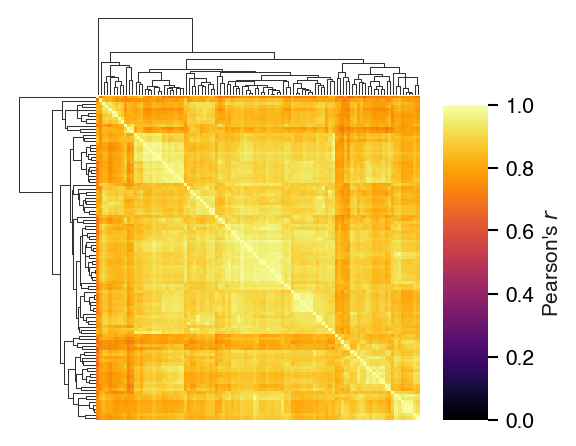

In [85]:
ax = sns.clustermap(cond_corr_mat, yticklabels=False, xticklabels=False, cmap='inferno',\
               cbar_pos=[1.0, 0.05, 0.1, 0.7], figsize=(3,3), vmin=0, vmax=1, cbar_kws={'label': r"Pearson's $r$"})
ax.ax_cbar.tick_params(labelsize=10)
if save_figs:
    plt.savefig(figs_dir+'/condition_corr_mat.pdf', bbox_inches='tight')

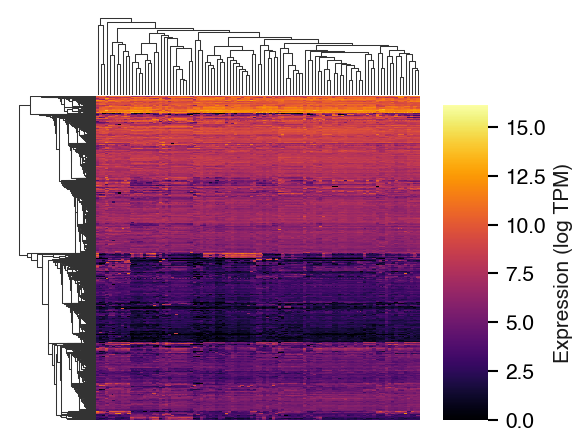

In [86]:
ax = sns.clustermap(exp_df.values, yticklabels=False, xticklabels=False, cmap='inferno',\
               cbar_pos=[1.0, 0.05, 0.1, 0.7], figsize=(3,3), vmin=0, cbar_kws={'label': r"Expression (log TPM)"})

## Example scatterplots of two highly correlated conditions

In [95]:
mask = np.ones(cond_corr_mat.values.shape, dtype=bool)
np.fill_diagonal(mask, 0)
print(mask.shape)

tempy = (cond_corr_mat.values*mask).flatten()
tempy.sort()
print(tempy[-20:])

(103, 103)
[0.98578763 0.98578763 0.98624725 0.98624725 0.98722368 0.98722368
 0.98850506 0.98850506 0.98907233 0.98907233 0.98952159 0.98952159
 0.99123083 0.99123083 0.9915522  0.9915522  0.99173211 0.99173211
 0.99264459 0.99264459]


In [96]:
example_index = -3
result = np.where(cond_corr_mat.values*mask == np.amax(tempy[example_index]))
print('Max', result)

Max (array([81, 82]), array([82, 81]))


In [97]:
idx_a = result[0][0]
idx_b = result[0][1]
cols = cond_corr_mat.columns
cond_corr_mat.loc[cols[idx_a]][cols[idx_b]]

0.9917321080566146

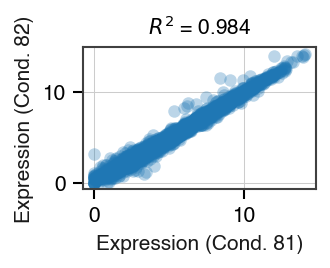

In [98]:
r, p = stats.pearsonr(exp_df[cols[idx_a]], exp_df[cols[idx_b]])
fig, ax = plt.subplots(figsize=(2.,1.25))
ax.plot(exp_df[cols[idx_a]], exp_df[cols[idx_b]], marker='o', linestyle='', alpha=0.3)
# ax.set_xticks([0, 5, 10, 15])
# ax.set_yticks([0, 5, 10, 15])
ax.set_xlabel('Expression (Cond. {})'.format(idx_a))
ax.set_ylabel('Expression (Cond. {})'.format(idx_b))
ax.set_title(r"$R^2$ = {:.3f}".format(r**2))
if save_figs:
    plt.savefig(figs_dir+'/max_condition_corr.pdf', bbox_inches='tight')

## Example scatterplots of two minimally correlated conditions

In [99]:
tempy = cond_corr_mat.values.flatten()
tempy.sort()
print(tempy[:10])

[0.64919392 0.64919392 0.65151461 0.65151461 0.67007013 0.67007013
 0.67682407 0.67682407 0.68024296 0.68024296]


In [100]:
example_index = 0
result = np.where(cond_corr_mat.values == tempy[example_index])
print('Min', result)

Min (array([44, 56]), array([56, 44]))


In [101]:
cols = cond_corr_mat.columns
idx_a = result[0][0]
idx_b = result[0][1]
cols = cond_corr_mat.columns
cond_corr_mat.loc[cols[idx_a]][cols[idx_b]]

0.6491939154909993

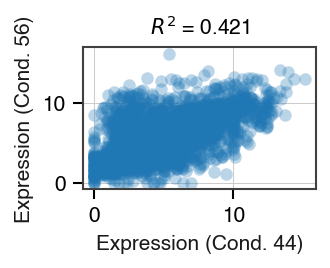

In [102]:
r, p = stats.pearsonr(exp_df[cols[idx_a]], exp_df[cols[idx_b]])
fig, ax = plt.subplots(figsize=(2.,1.25))
ax.plot(exp_df[cols[idx_a]], exp_df[cols[idx_b]], marker='o', linestyle='', alpha=0.3)
ax.set_xlabel('Expression (Cond. {})'.format(idx_a))
ax.set_ylabel('Expression (Cond. {})'.format(idx_b))
ax.set_title(r"$R^2$ = {:.3f}".format(r**2))
# ax.set_xticks([0, 5, 10, 15])
# ax.set_yticks([0, 5, 10, 15])
if save_figs:
    plt.savefig(figs_dir+'/min_condition_corr.pdf', bbox_inches='tight')

## Looking at gene expression vs various dispersion metrics

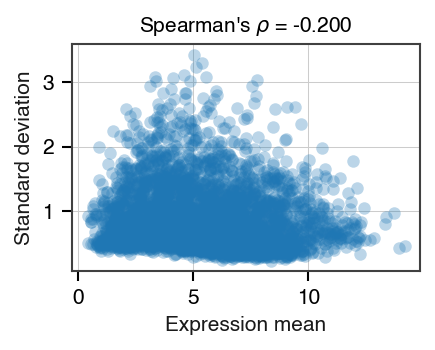

In [103]:
x_vals = exp_df.mean(axis=1)
y_vals = exp_df.std(axis=1)
rho, p = stats.spearmanr(x_vals, y_vals)

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(x_vals, y_vals, marker='o', linestyle='', alpha=0.3)
ax.set_xlabel('Expression mean')
ax.set_ylabel('Standard deviation')
ax.set_title(r"Spearman's $\rho$ = {:.3f}".format(rho));
if save_figs:
    plt.savefig(figs_dir+'/sdev_vs_mean.pdf', bbox_inches='tight')

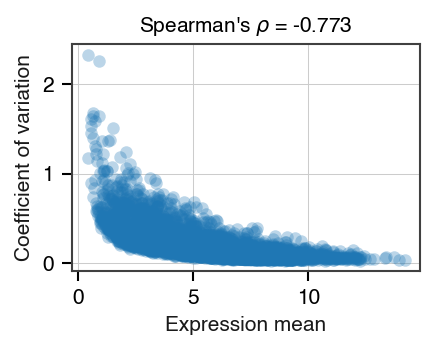

In [104]:
x_vals = exp_df.mean(axis=1)
y_vals = np.power(exp_df.std(axis=1), 1)/np.power(exp_df.mean(axis=1), 1)
rho, p = stats.spearmanr(x_vals, y_vals)

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(x_vals, y_vals, marker='o', linestyle='', alpha=0.3)
ax.set_xlabel('Expression mean')
ax.set_ylabel('Coefficient of variation')
ax.set_title(r"Spearman's $\rho$ = {:.3f}".format(rho));
if save_figs:
    plt.savefig(figs_dir+'/cv_vs_mean.pdf', bbox_inches='tight')

# Explore growth rate data

Slowest DT: 9.902102579427789
Fastest DT: 0.4881318172957361
Slowest rate: 0.07
Fastest rate: 1.42


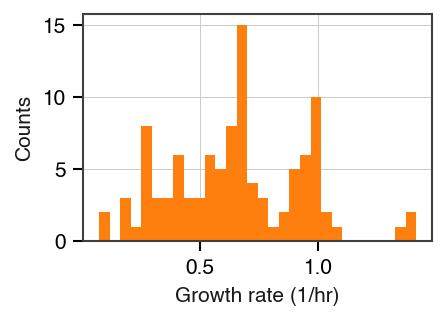

In [129]:
fig, ax = plt.subplots(figsize=(3,2))
ax.hist(meta_df['Growth Rate (1/hr)'], 30, facecolor=color_cycle[1])
ax.set_xlabel('Growth rate (1/hr)')
ax.set_ylabel('Counts')
# assert meta_df['Growth Rate (1/hr)'].max() < 1.5
# ax.set_xlim(0, 1.5)
ax.set_title('')
if save_figs:
    plt.savefig(figs_dir+'/growth_rate_hist.pdf', bbox_inches='tight')
print('Slowest DT: {}'.format(np.log(2)/meta_df['Growth Rate (1/hr)'].min()))
print('Fastest DT: {}'.format(np.log(2)/meta_df['Growth Rate (1/hr)'].max()))
print('Slowest rate: {}'.format(meta_df['Growth Rate (1/hr)'].min()))
print('Fastest rate: {}'.format(meta_df['Growth Rate (1/hr)'].max()))

## Assess individual gene correlations with the growth rate data

I'm only doing a single randomization/permutation here, and it should of course be noted that this randomization is a bit unfair since it destroys the underlying correlation structure between conditions. However, a permutation strategy that accounts for that structure would be very difficult and the only point here is to show that there are some genes that are more/less correlated with growth than you might expect by chance alone.

In [109]:
tempy = []
tempy_rando = []
for index in exp_df.index:
    r, p = stats.pearsonr(exp_df.loc[index], meta_df['Growth Rate (1/hr)'])
    tempy.append((index, r, p))
    r, p = stats.pearsonr(np.random.permutation(exp_df.loc[index].values), meta_df['Growth Rate (1/hr)'])
    tempy_rando.append((index, r, p))
tempy.sort(key=lambda x: x[1])
tempy_rando.sort(key=lambda x: x[1])

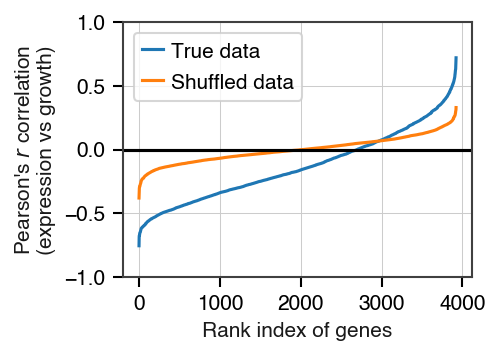

In [110]:
fig, ax = plt.subplots(figsize=(3,2.25))
ax.plot([i[1] for i in tempy], label='True data')
ax.plot([i[1] for i in tempy_rando], label='Shuffled data')
ax.axhline(0, c='k')
ax.set_xlabel('Rank index of genes')
ax.set_ylabel('Pearson\'s $r$ correlation\n(expression vs growth)')
plt.legend()
ax.set_ylim(-1.0, 1.0)
if save_figs:
    plt.savefig(figs_dir+'/rank_genes_growth.pdf', bbox_inches='tight')

-0.7550622608400182 0.7202138708192735


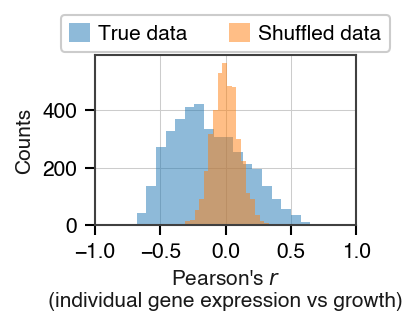

In [111]:
fig, ax = plt.subplots(figsize=(2.25,1.5))
ax.hist([i[1] for i in tempy], 20, label='True data', alpha=0.5)
ax.hist([i[1] for i in tempy_rando], 20, label='Shuffled data', alpha=0.5)
ax.set_xlabel('Pearson\'s $r$\n(individual gene expression vs growth)')
ax.set_ylabel('Counts')
leg = ax.legend(framealpha=1, ncol=2, loc='upper left', bbox_to_anchor=(-0.17, 1.3))
ax.set_xlim(-1.0, 1.0)
if save_figs:
    plt.savefig(figs_dir+'/hist_genes_growth.pdf', bbox_inches='tight')
print(np.min([i[1] for i in tempy]), np.max([i[1] for i in tempy]))

## Finding representative examples of genes

b4658_2 3.06439444395583
b4658_1 3.7028492557703894
b1533 5.664388499259191
b2538 4.9514232943572605
b1985 3.936318100587961
b1259 2.488104187235281
b0953 9.436766861121992
b3073 7.080314209979955
b1607 4.750192150841198
b1489 3.934471462396405


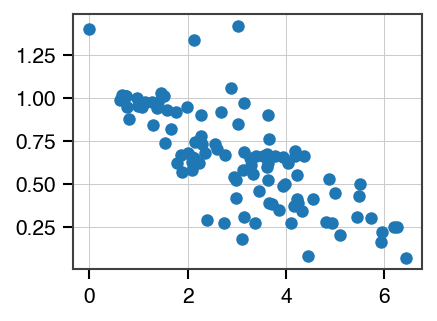

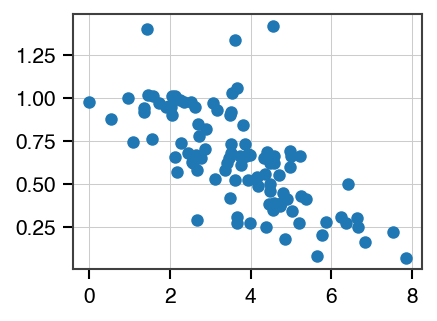

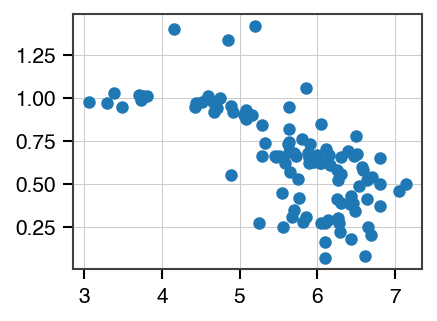

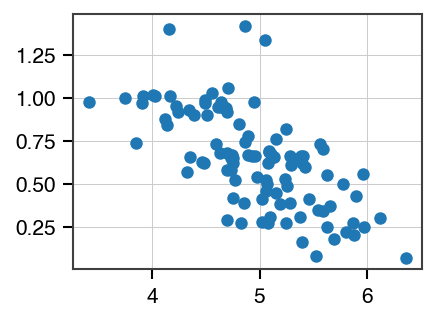

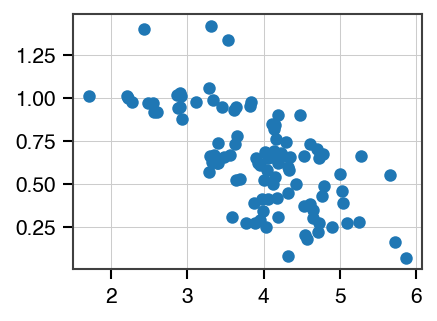

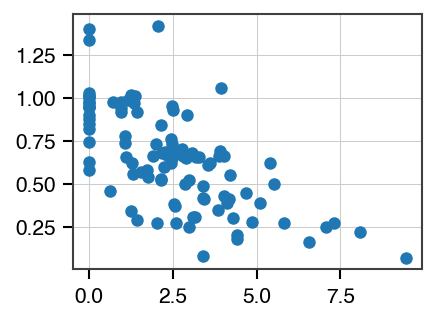

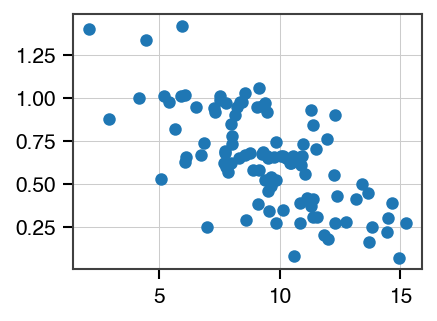

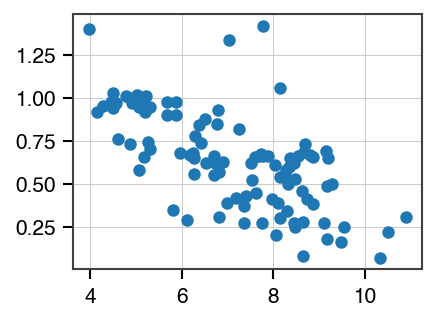

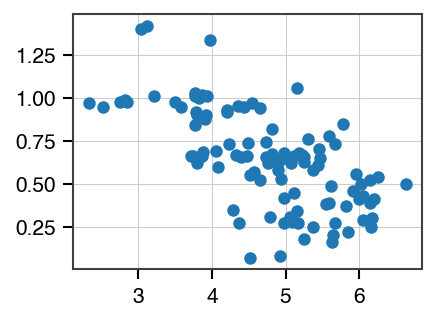

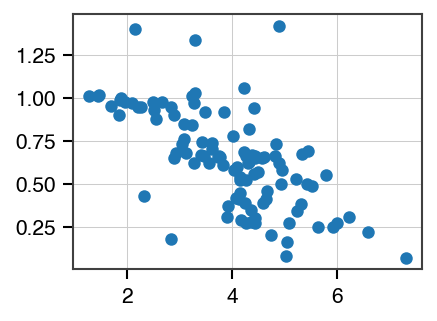

In [112]:
for i in tempy[:10]:
    fig, ax = plt.subplots()
    ax.plot(exp_df.loc[i[0]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='')
    print(i[0], exp_df.loc[i[0]].mean())

b3339 14.182324082298154
b3176 8.48826991062256
b0893 9.684601779030348
b3294 11.718292971763805
b3313 11.665870349044274
b1095 9.757356018551992
b0154 8.213076960884367
b4328 6.41991565443437
b0170 10.801267964925856
b2780 9.504768951630112


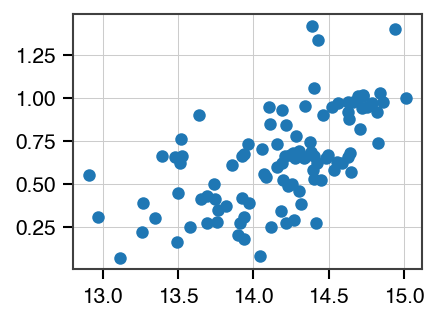

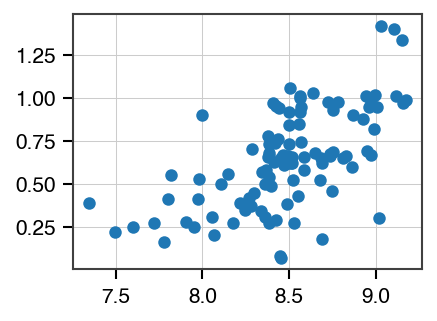

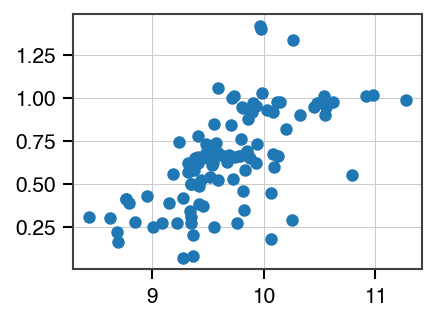

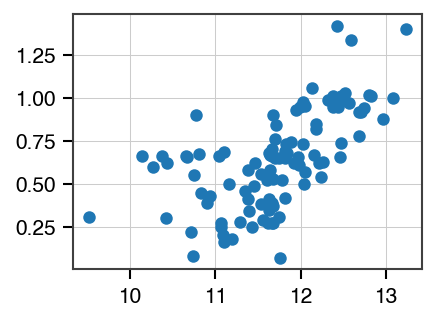

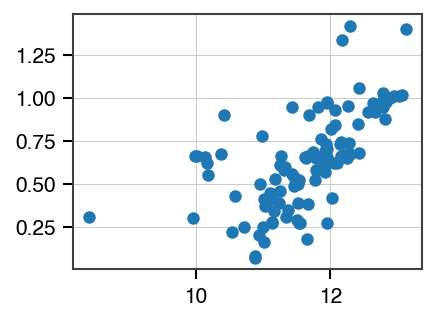

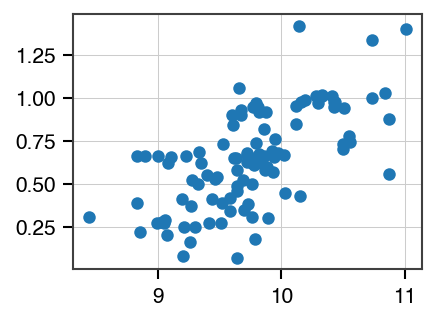

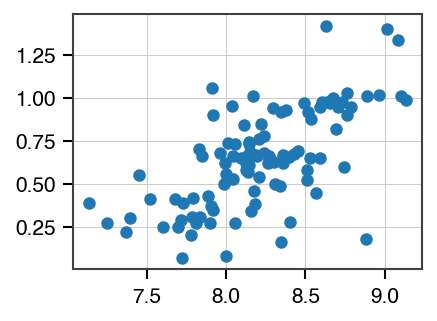

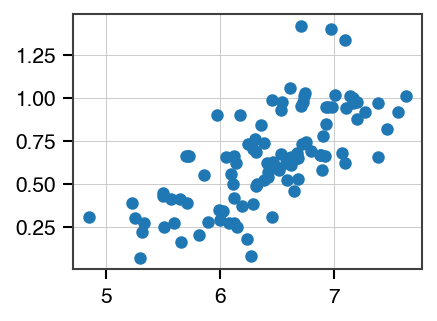

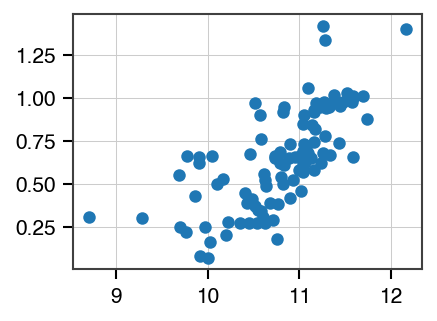

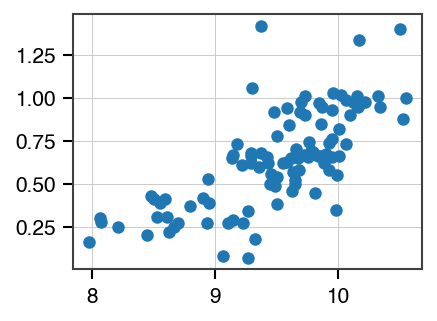

In [113]:
for i in tempy[-10:]:
    fig, ax = plt.subplots()
    ax.plot(exp_df.loc[i[0]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='')
    print(i[0], exp_df.loc[i[0]].mean())

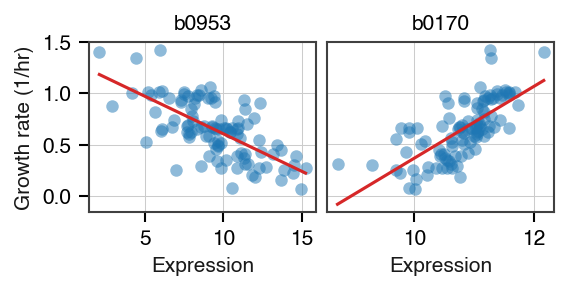

In [124]:
ltags = ['b0953', 'b0170']

fig, ax_arr = plt.subplots(figsize=(4,1.5),ncols=2, sharey=True)
ax_arr[0].plot(exp_df.loc[ltags[0]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='', alpha=0.5)
a, b, c, d, e = stats.linregress(exp_df.loc[ltags[0]], meta_df['Growth Rate (1/hr)'])
x_vals = np.linspace(min(exp_df.loc[ltags[0]]), max(exp_df.loc[ltags[0]]), 10)
y_vals = (a*x_vals) + b
ax_arr[0].plot(x_vals, y_vals, marker='', linestyle='-', c=color_cycle[3])

ax_arr[0].set_title(ltags[0]);
ax_arr[0].set_xlabel('Expression');
ax_arr[0].set_ylabel('Growth rate (1/hr)');
ax_arr[1].plot(exp_df.loc[ltags[1]], meta_df['Growth Rate (1/hr)'], marker='o', linestyle='', alpha=0.5)
a, b, c, d, e = stats.linregress(exp_df.loc[ltags[1]], meta_df['Growth Rate (1/hr)'])
x_vals = np.linspace(min(exp_df.loc[ltags[1]]), max(exp_df.loc[ltags[1]]), 10)
y_vals = (a*x_vals) + b
ax_arr[1].plot(x_vals, y_vals, marker='', linestyle='-', c=color_cycle[3])
ax_arr[1].set_title(ltags[1]);
ax_arr[1].set_xlabel('Expression');
ax_arr[0].set_yticks([0, 0.5, 1, 1.5])
plt.tick_params(axis='y', which='both', left=False)

plt.subplots_adjust(wspace=0.05)
if save_figs:
    plt.savefig(figs_dir+'/example_genes_with_growth.pdf', bbox_inches='tight')

# Expression vs growth correlation

In [125]:
fitted = smf.ols('mean ~ lin_r', data=exp_summary_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     637.4
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          1.89e-130
Time:                        16:47:00   Log-Likelihood:                -8787.8
No. Observations:                3923   AIC:                         1.758e+04
Df Residuals:                    3921   BIC:                         1.759e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0178      0.040    148.865      0.000       5.939       6.097
lin_r          3.3602      0.133     25.248      0.000       3.099       3.621
==============================================================================
Omnibus:                       17.654   Durbin-Watson:                   1.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.597
Skew:                           0.078   Prob(JB):                     0.000677
Kurtosis:                       2.745   Cond. No.                         3.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

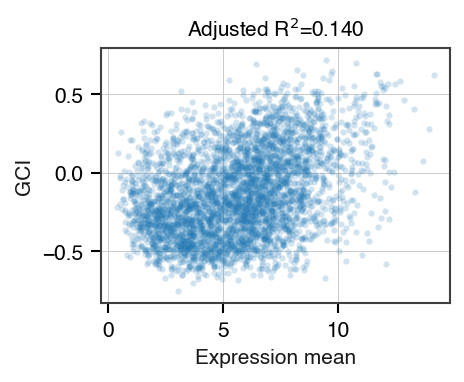

In [126]:
fig, ax = plt.subplots(figsize=(3,2.25))
ax.plot(exp_summary_df['mean'], exp_summary_df['lin_r'], marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('Expression mean')
ax.set_ylabel('GCI')
ax.set_title(r'Adjusted R$^2$={:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/mean_vs_GCI.pdf', bbox_inches='tight')